### This notebook looks at the communicability within and across ntwx with and without SC lesions / re-added Ntwx

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 7.71 s, sys: 65.1 ms, total: 7.78 s
Wall time: 15.7 s


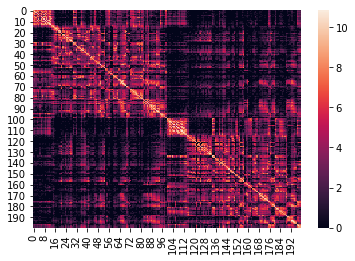

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 1s, sys: 355 ms, total: 1min 1s
Wall time: 1min 5s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.37 s, sys: 72.1 ms, total: 1.44 s
Wall time: 1.44 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

###  og whobpyt + lesion

In [19]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_smt_lesion = []
all_subs_dan_lesion = []
all_subs_van_lesion = []
all_subs_lim_lesion = []
all_subs_fpn_lesion = []
all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)


CPU times: user 1min 22s, sys: 1.63 s, total: 1min 24s
Wall time: 1min 44s


In [20]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_smt_lesion,
                        all_subs_dan_lesion,all_subs_van_lesion,
                        all_subs_lim_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

### re-add ntwx

In [28]:
re_add_lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_and_ReAdd_WhoBPyT_200_subs'

In [29]:
%%time

# re_add_all_subs_og_whobpyt = []
re_add_all_subs_vis_lesion = []
re_add_all_subs_smt_lesion = []
re_add_all_subs_dan_lesion = []
re_add_all_subs_van_lesion = []
re_add_all_subs_lim_lesion = []
re_add_all_subs_fpn_lesion = []
re_add_all_subs_dmn_lesion = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
#     ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
#     re_add_all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_vis_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_vis_lesion.append(ss_vis_lesion)
    

    ss_smt_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_smt_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_smt_lesion.append(ss_smt_lesion)

    ss_dan_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dan_lesion_re_add_vis_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dan_lesion.append(ss_dan_lesion)
    

    ss_van_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_van_lesion_re_add_dan_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_van_lesion.append(ss_van_lesion)

    
    ss_lim_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_lim_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_lim_lesion.append(ss_lim_lesion)

    
    ss_fpn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_fpn_lesion_re_add_dmn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_fpn_lesion.append(ss_fpn_lesion)

    
    ss_dmn_lesion = np.loadtxt(re_add_lesion_whobpyt_path + '/dummy_Subj_{0}_dmn_lesion_re_add_fpn_fc_con_mat.txt'.format(sub_id))
    re_add_all_subs_dmn_lesion.append(ss_dmn_lesion)
    
    del ss_vis_lesion,ss_smt_lesion,ss_dan_lesion,ss_van_lesion,ss_lim_lesion,ss_fpn_lesion,ss_dmn_lesion

CPU times: user 1min 17s, sys: 1.83 s, total: 1min 18s
Wall time: 2min 12s


In [21]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [22]:
# corrs_list

In [23]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [24]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [25]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [26]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

In [27]:
# sns.heatmap(distance)

## Communicability

In [32]:
# intact sc

In [30]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 6.22 s, sys: 138 ms, total: 6.36 s
Wall time: 6.47 s


In [33]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [39]:
def structurally_re_add_func_ntwx(a,b,c,d, a1,b1,c1,d1,sc):
    
    # a,b,c,d, isolates the target network;
    # a1,b1,c1,d1 re-adds the specific network.
    
    # isolate the target matrix
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
    # re-add the specified ntwx
    modified_matrix2 = modified_matrix.copy()
    
    modified_matrix2[a:b, a1:b1] = sc[a:b, a1:b1] #lh
    modified_matrix2[c:d, c1:d1] = sc[c:d, c1:d1] #rh
    
    modified_matrix2[a:b, c1:d1] = sc[a:b, c1:d1] #lhrh
    modified_matrix2[c:d, a1:b1] = sc[c:d, a1:b1] #rhlh
    
#     modified_matrix2 = modified_matrix2/np.linalg.norm(modified_matrix2)
    
    return modified_matrix2

In [35]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

### lesion sc

In [38]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 134 ms, sys: 137 ms, total: 271 ms
Wall time: 268 ms


### lesion sc communicability

In [41]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 43 s, sys: 928 ms, total: 44 s
Wall time: 44 s


### lesion + re_add sc

In [40]:
%%time
all_subs_sc_vis_lesion_re_add_ntwx = []
all_subs_sc_smt_lesion_re_add_ntwx = []
all_subs_sc_dan_lesion_re_add_ntwx = []
all_subs_sc_van_lesion_re_add_ntwx = []
all_subs_sc_lim_lesion_re_add_ntwx = []
all_subs_sc_fpn_lesion_re_add_ntwx = []
all_subs_sc_dmn_lesion_re_add_ntwx = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_re_add_func_ntwx(0,14,100,115, 30,43,134,147, sub_sc)
    all_subs_sc_vis_lesion_re_add_ntwx.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_re_add_func_ntwx(14,30,115,134, 30,43,134,147, sub_sc)
    all_subs_sc_smt_lesion_re_add_ntwx.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_re_add_func_ntwx(30,43,134,147, 0,14,100,115, sub_sc)
    all_subs_sc_dan_lesion_re_add_ntwx.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_re_add_func_ntwx(43,54,147,158, 30,43,134,147, sub_sc)
    all_subs_sc_van_lesion_re_add_ntwx.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_re_add_func_ntwx(54,60,158,164, 73,100,181,200, sub_sc)
    all_subs_sc_lim_lesion_re_add_ntwx.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_re_add_func_ntwx(60,73,164,181, 73,100,181,200, sub_sc)
    all_subs_sc_fpn_lesion_re_add_ntwx.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_re_add_func_ntwx(73,100,181,200, 60,73,164,181, sub_sc)
    all_subs_sc_dmn_lesion_re_add_ntwx.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 164 ms, sys: 209 ms, total: 373 ms
Wall time: 371 ms


### lesion + re-add sc communicability

In [42]:
%%time

all_subs_communicability_sc_vis_lesion_re_add = []
all_subs_communicability_sc_smt_lesion_re_add = []
all_subs_communicability_sc_dan_lesion_re_add = []
all_subs_communicability_sc_van_lesion_re_add = []
all_subs_communicability_sc_lim_lesion_re_add = []
all_subs_communicability_sc_fpn_lesion_re_add = []
all_subs_communicability_sc_dmn_lesion_re_add = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_vis_lesion_re_add.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_smt_lesion_re_add.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_dan_lesion_re_add.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_van_lesion_re_add.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_lim_lesion_re_add.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_fpn_lesion_re_add.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion_re_add_ntwx[i])
    all_subs_communicability_sc_dmn_lesion_re_add.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 42.7 s, sys: 682 ms, total: 43.4 s
Wall time: 43.4 s


## WITHIN NETWORKS

In [43]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_sc

In [44]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

### lesion

In [45]:
%%time

intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [46]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [47]:
all_sc_comm_means = [intact_sc_comm_means,
vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [48]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

### lesion + re-add

In [49]:
%%time

# intact_sc_comm_means_re_add, intact_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means_re_add, vis_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion_re_add)
smt_lesion_sc_comm_means_re_add, smt_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion_re_add)
dan_lesion_sc_comm_means_re_add, dan_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion_re_add)
van_lesion_sc_comm_means_re_add, van_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion_re_add)
lim_lesion_sc_comm_means_re_add, lim_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion_re_add)
fpn_lesion_sc_comm_means_re_add, fpn_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion_re_add)
dmn_lesion_sc_comm_means_re_add, dmn_lesion_sc_comm_all_subs_re_add = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion_re_add)

CPU times: user 892 ms, sys: 161 ms, total: 1.05 s
Wall time: 1.04 s


In [53]:
vis_lesion_sc_comm_means_re_add

[0.034327620595291555,
 0.01785735769991371,
 0.01284392628608023,
 0.010689114053653866,
 0.02123162275506727,
 0.009733693827149345,
 0.012048267890586849]

In [54]:
vis_lesion_sc_comm_means

[0.037282824564964144,
 0.01785735769991371,
 0.01284392628608023,
 0.010689114053653866,
 0.02123162275506727,
 0.009733693827149345,
 0.012048267890586849]

#### vis lesion comm stats

In [50]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(vis_lesion_sc_comm_all_subs_re_add[i], vis_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -19.317598654926158
P-Value: 3.9092745818252484e-59 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


####  smt lesion comm stats

In [55]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(smt_lesion_sc_comm_all_subs_re_add[i], smt_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: -42.6688222687811
P-Value: 1.4135881242920948e-150 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


#### dan lesion comm stats

In [56]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(dan_lesion_sc_comm_all_subs_re_add[i], dan_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: -21.04802222647561
P-Value: 1.203090886492801e-66 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


#### van lesion comm stats

In [57]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(van_lesion_sc_comm_all_subs_re_add[i], van_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: -36.96313523447816
P-Value: 9.269275146737927e-131 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


#### lim lesion comm stats

In [58]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(lim_lesion_sc_comm_all_subs_re_add[i], lim_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: -54.24881468113145
P-Value: 5.703552278191675e-186 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


#### fpn lesion comm stats

In [59]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(fpn_lesion_sc_comm_all_subs_re_add[i], fpn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: -84.83293519656817
P-Value: 5.879002467976254e-257 

-------------------
Network =  DMN
T-Statistic: 0.0
P-Value: 1.0 

-------------------


#### dmn lesion comm stats

In [61]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(dmn_lesion_sc_comm_all_subs_re_add[i], dmn_lesion_sc_comm_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  SomMot
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DorsAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  VentAttn
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  Limbic
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  FPN
T-Statistic: 0.0
P-Value: 1.0 

-------------------
Network =  DMN
T-Statistic: -49.5226903327486
P-Value: 3.032105793387702e-172 

-------------------


### bar plots

In [63]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

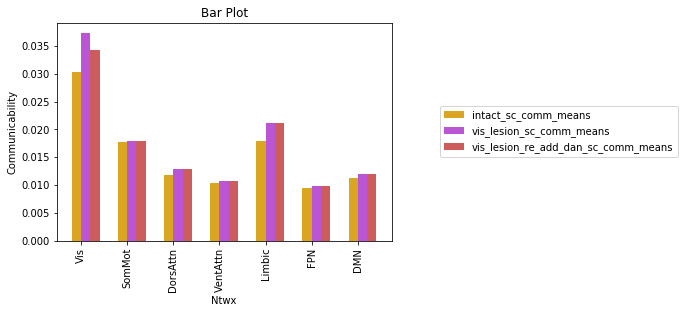

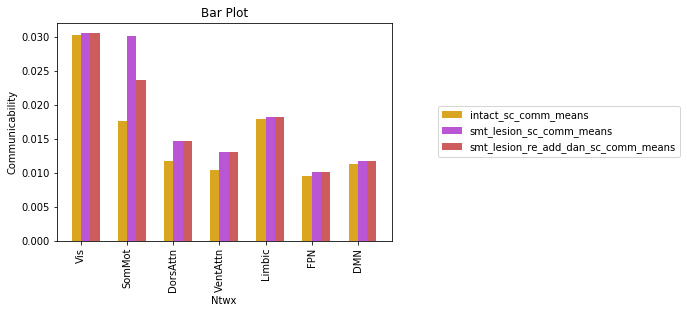

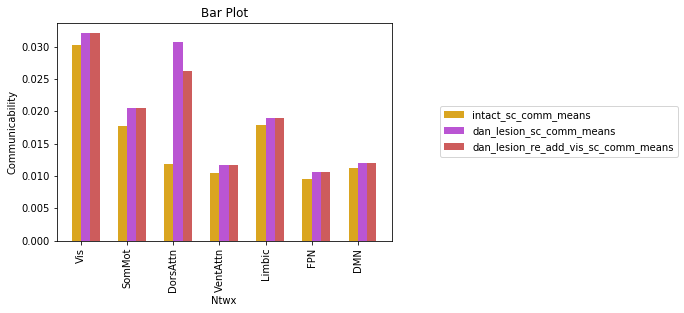

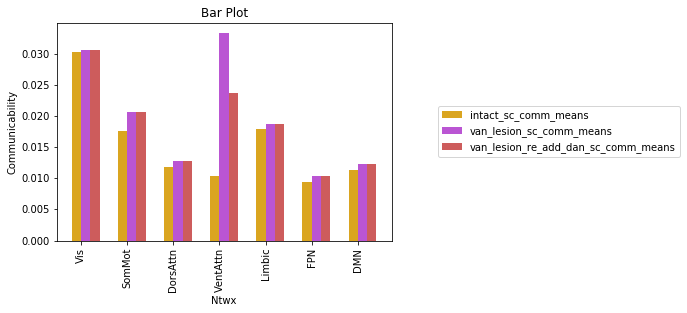

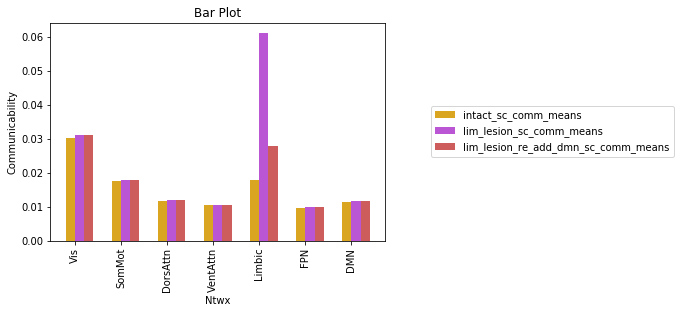

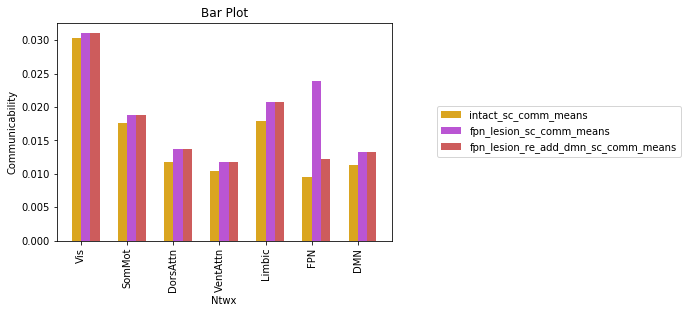

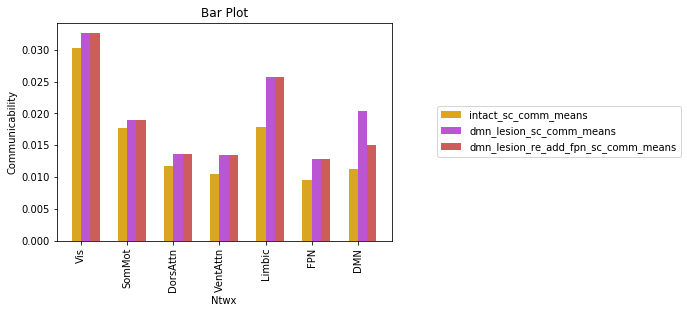

In [68]:
# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], vis_lesion_sc_comm_means, width, label='vis_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], vis_lesion_sc_comm_means_re_add, width, label='vis_lesion_re_add_dan_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], smt_lesion_sc_comm_means, width, label='smt_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], smt_lesion_sc_comm_means_re_add, width, label='smt_lesion_re_add_dan_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dan_lesion_sc_comm_means, width, label='dan_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], dan_lesion_sc_comm_means_re_add, width, label='dan_lesion_re_add_vis_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], van_lesion_sc_comm_means, width, label='van_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], van_lesion_sc_comm_means_re_add, width, label='van_lesion_re_add_dan_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], lim_lesion_sc_comm_means, width, label='lim_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], lim_lesion_sc_comm_means_re_add, width, label='lim_lesion_re_add_dmn_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], fpn_lesion_sc_comm_means, width, label='fpn_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], fpn_lesion_sc_comm_means_re_add, width, label='fpn_lesion_re_add_dmn_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.20  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dmn_lesion_sc_comm_means, width, label='dmn_lesion_sc_comm_means',color='mediumorchid')
rects2 = ax.bar([i + 2*width for i in x], dmn_lesion_sc_comm_means_re_add, width, label='dmn_lesion_re_add_fpn_sc_comm_means',color='indianred')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

## BETWEEN NTWX

In [69]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_sc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_sc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_sc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_sc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_sc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_sc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_sommot_sc, mean_ntwx_to_dorsattn_sc, mean_ntwx_to_ventattn_sc, mean_ntwx_to_limbic_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [70]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [71]:
def get_between_ntwx_sc_communicability_stats_version(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
#         ntwx_lesion_means_all_subs = [all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,
#                                       all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,
#                                       all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,
#                                       all_subs_dmn_to_other_ntwx_lesions]
        
    
    return all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [72]:
stats_intact_sc_vis_to_other_ntwx, stats_intact_sc_smt_to_other_ntwx, stats_intact_sc_dan_to_other_ntwx, stats_intact_sc_van_to_other_ntwx, stats_intact_sc_lim_to_other_ntwx, stats_intact_sc_fpn_to_other_ntwx, stats_intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_stats_version(all_subs_communicability_sc)


### lesion sc

In [75]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.16 s, sys: 239 ms, total: 6.4 s
Wall time: 6.37 s


In [76]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [77]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

### lesion + re-add sc

In [78]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

# intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_re_add_vis_to_other_ntwx, vis_lesion_re_add_smt_to_other_ntwx, vis_lesion_re_add_dan_to_other_ntwx, vis_lesion_re_add_van_to_other_ntwx, vis_lesion_re_add_lim_to_other_ntwx, vis_lesion_re_add_fpn_to_other_ntwx, vis_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion_re_add)

smt_lesion_re_add_vis_to_other_ntwx, smt_lesion_re_add_smt_to_other_ntwx, smt_lesion_re_add_dan_to_other_ntwx, smt_lesion_re_add_van_to_other_ntwx, smt_lesion_re_add_lim_to_other_ntwx, smt_lesion_re_add_fpn_to_other_ntwx, smt_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion_re_add)

dan_lesion_re_add_vis_to_other_ntwx, dan_lesion_re_add_smt_to_other_ntwx, dan_lesion_re_add_dan_to_other_ntwx, dan_lesion_re_add_van_to_other_ntwx, dan_lesion_re_add_lim_to_other_ntwx, dan_lesion_re_add_fpn_to_other_ntwx, dan_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion_re_add)

van_lesion_re_add_vis_to_other_ntwx, van_lesion_re_add_smt_to_other_ntwx, van_lesion_re_add_dan_to_other_ntwx, van_lesion_re_add_van_to_other_ntwx, van_lesion_re_add_lim_to_other_ntwx, van_lesion_re_add_fpn_to_other_ntwx, van_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion_re_add)

lim_lesion_re_add_vis_to_other_ntwx, lim_lesion_re_add_smt_to_other_ntwx, lim_lesion_re_add_dan_to_other_ntwx, lim_lesion_re_add_van_to_other_ntwx, lim_lesion_re_add_lim_to_other_ntwx, lim_lesion_re_add_fpn_to_other_ntwx, lim_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion_re_add)

fpn_lesion_re_add_vis_to_other_ntwx, fpn_lesion_re_add_smt_to_other_ntwx, fpn_lesion_re_add_dan_to_other_ntwx, fpn_lesion_re_add_van_to_other_ntwx, fpn_lesion_re_add_lim_to_other_ntwx, fpn_lesion_re_add_fpn_to_other_ntwx, fpn_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion_re_add)

dmn_lesion_re_add_vis_to_other_ntwx, dmn_lesion_re_add_smt_to_other_ntwx, dmn_lesion_re_add_dan_to_other_ntwx, dmn_lesion_re_add_van_to_other_ntwx, dmn_lesion_re_add_lim_to_other_ntwx, dmn_lesion_re_add_fpn_to_other_ntwx, dmn_lesion_re_add_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion_re_add)

CPU times: user 5.42 s, sys: 144 ms, total: 5.57 s
Wall time: 5.52 s


In [79]:
vis_lesion_re_add_between_other_ntwx = [vis_lesion_re_add_vis_to_other_ntwx, vis_lesion_re_add_smt_to_other_ntwx, vis_lesion_re_add_dan_to_other_ntwx, vis_lesion_re_add_van_to_other_ntwx, vis_lesion_re_add_lim_to_other_ntwx, vis_lesion_re_add_fpn_to_other_ntwx, vis_lesion_re_add_dmn_to_other_ntwx]
smt_lesion_re_add_between_other_ntwx = [smt_lesion_re_add_vis_to_other_ntwx, smt_lesion_re_add_smt_to_other_ntwx, smt_lesion_re_add_dan_to_other_ntwx, smt_lesion_re_add_van_to_other_ntwx, smt_lesion_re_add_lim_to_other_ntwx, smt_lesion_re_add_fpn_to_other_ntwx, smt_lesion_re_add_dmn_to_other_ntwx]
dan_lesion_re_add_between_other_ntwx = [dan_lesion_re_add_vis_to_other_ntwx, dan_lesion_re_add_smt_to_other_ntwx, dan_lesion_re_add_dan_to_other_ntwx, dan_lesion_re_add_van_to_other_ntwx, dan_lesion_re_add_lim_to_other_ntwx, dan_lesion_re_add_fpn_to_other_ntwx, dan_lesion_re_add_dmn_to_other_ntwx]
van_lesion_re_add_between_other_ntwx = [van_lesion_re_add_vis_to_other_ntwx, van_lesion_re_add_smt_to_other_ntwx, van_lesion_re_add_dan_to_other_ntwx, van_lesion_re_add_van_to_other_ntwx, van_lesion_re_add_lim_to_other_ntwx, van_lesion_re_add_fpn_to_other_ntwx, van_lesion_re_add_dmn_to_other_ntwx]
lim_lesion_re_add_between_other_ntwx = [lim_lesion_re_add_vis_to_other_ntwx, lim_lesion_re_add_smt_to_other_ntwx, lim_lesion_re_add_dan_to_other_ntwx, lim_lesion_re_add_van_to_other_ntwx, lim_lesion_re_add_lim_to_other_ntwx, lim_lesion_re_add_fpn_to_other_ntwx, lim_lesion_re_add_dmn_to_other_ntwx]
fpn_lesion_re_add_between_other_ntwx = [fpn_lesion_re_add_vis_to_other_ntwx, fpn_lesion_re_add_smt_to_other_ntwx, fpn_lesion_re_add_dan_to_other_ntwx, fpn_lesion_re_add_van_to_other_ntwx, fpn_lesion_re_add_lim_to_other_ntwx, fpn_lesion_re_add_fpn_to_other_ntwx, fpn_lesion_re_add_dmn_to_other_ntwx]
dmn_lesion_re_add_between_other_ntwx = [dmn_lesion_re_add_vis_to_other_ntwx, dmn_lesion_re_add_smt_to_other_ntwx, dmn_lesion_re_add_dan_to_other_ntwx, dmn_lesion_re_add_van_to_other_ntwx, dmn_lesion_re_add_lim_to_other_ntwx, dmn_lesion_re_add_fpn_to_other_ntwx, dmn_lesion_re_add_dmn_to_other_ntwx]

In [80]:
vis_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in vis_lesion_re_add_between_other_ntwx]
smt_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in smt_lesion_re_add_between_other_ntwx]
dan_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in dan_lesion_re_add_between_other_ntwx]
van_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in van_lesion_re_add_between_other_ntwx]
lim_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in lim_lesion_re_add_between_other_ntwx]
fpn_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_re_add_between_other_ntwx]
dmn_lesion_re_add_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_re_add_between_other_ntwx]

#### Visual 

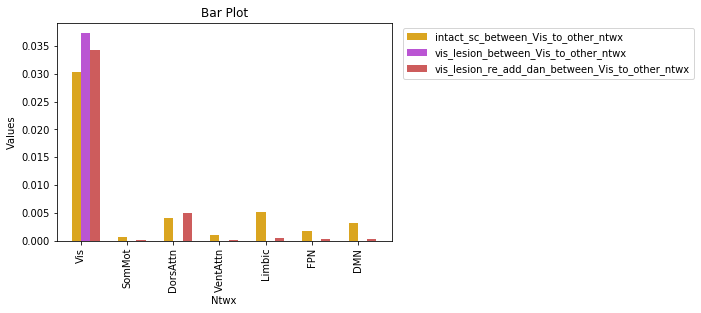

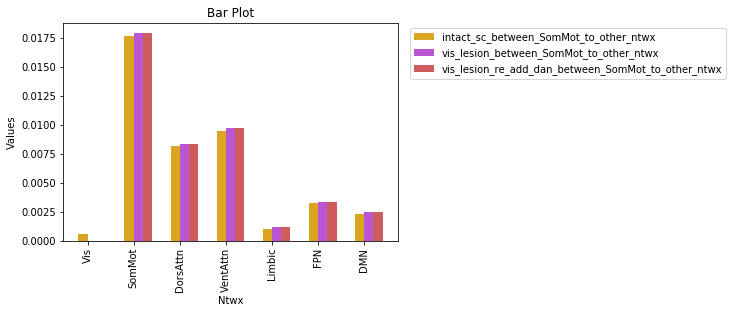

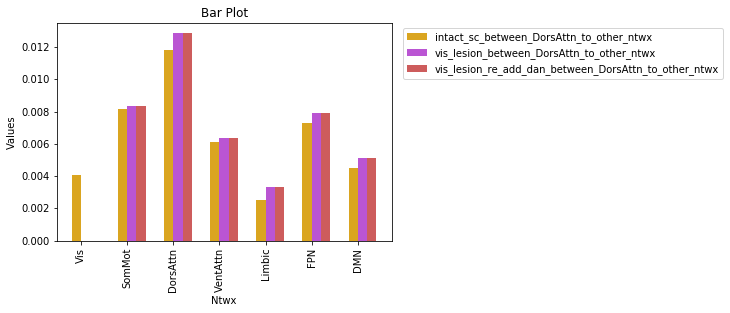

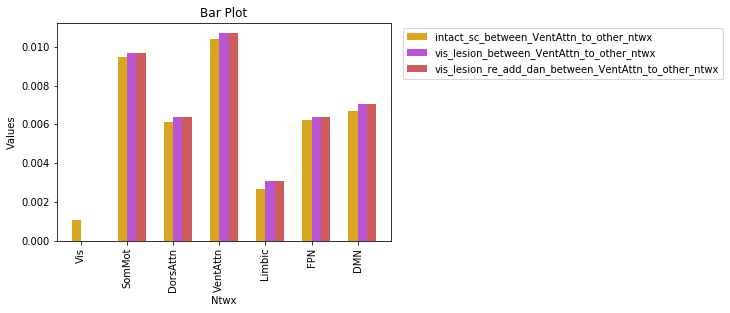

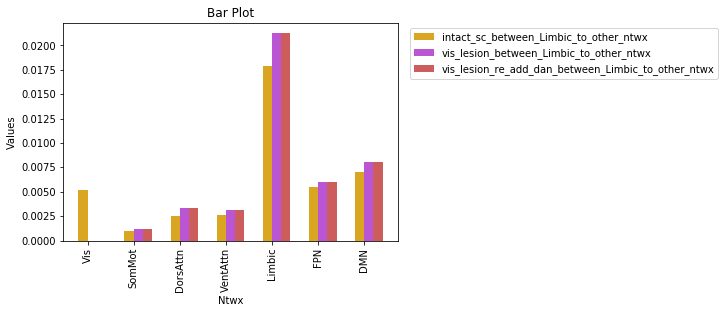

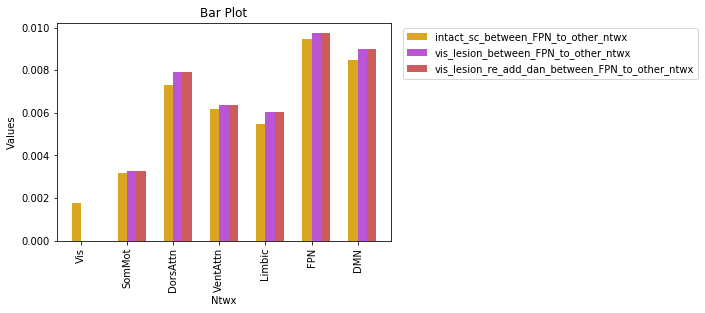

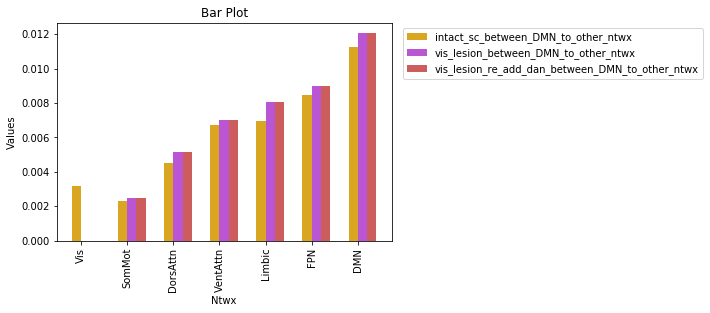

In [82]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], vis_lesion_between_other_ntwx[j], width, label='vis_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], vis_lesion_re_add_between_other_ntwx[j], width, label='vis_lesion_re_add_dan_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomatoMotor

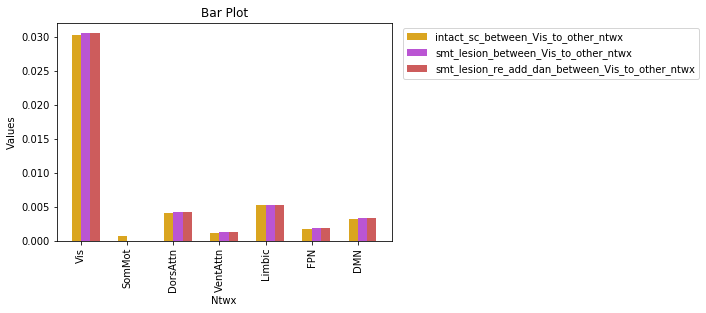

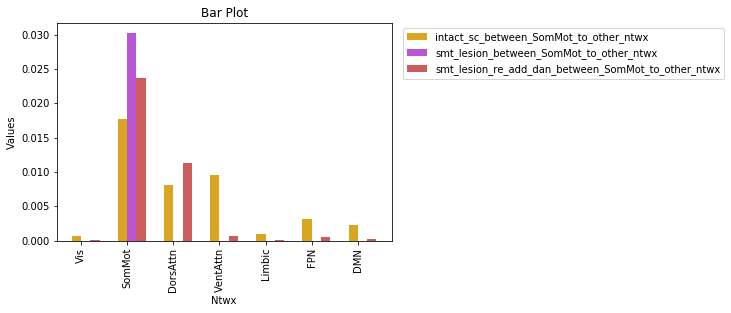

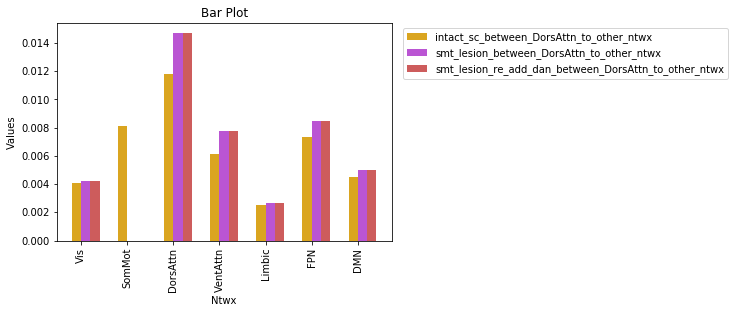

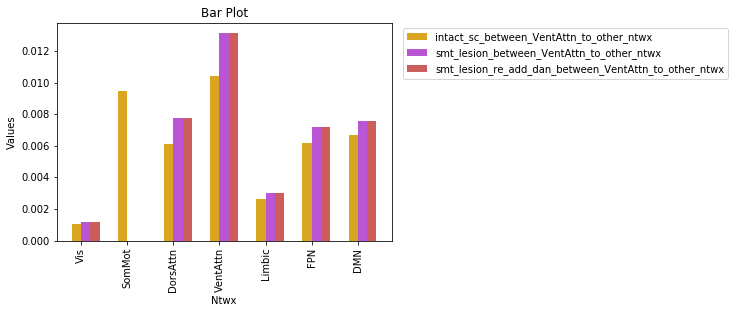

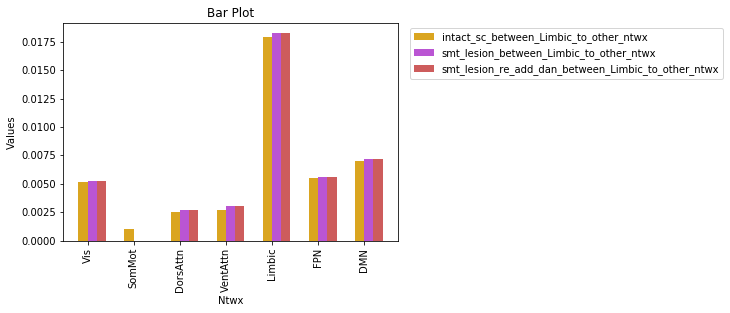

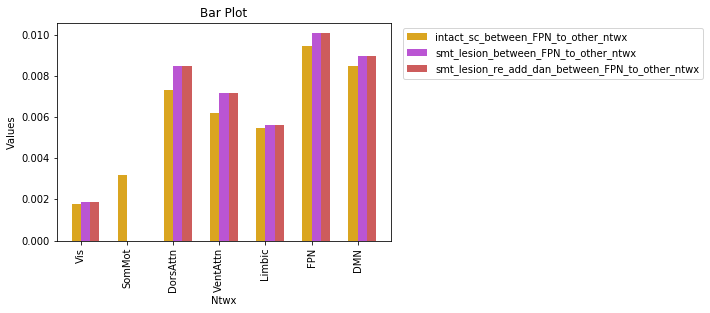

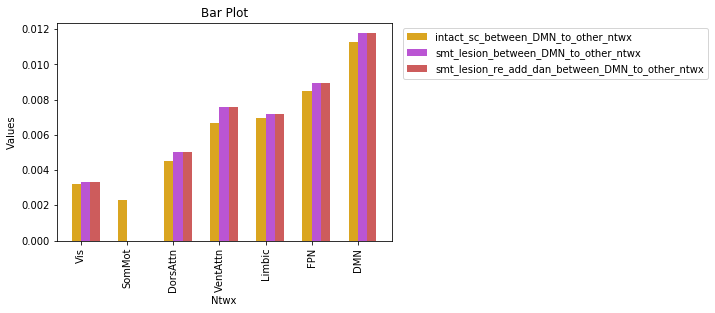

In [83]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], smt_lesion_between_other_ntwx[j], width, label='smt_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], smt_lesion_re_add_between_other_ntwx[j], width, label='smt_lesion_re_add_dan_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

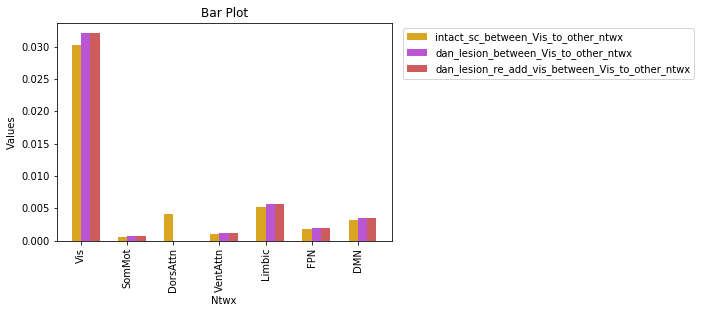

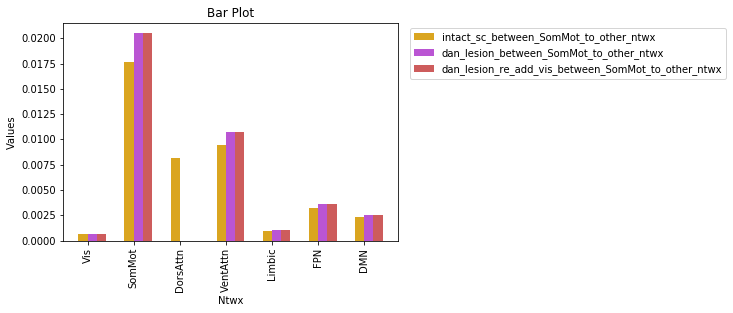

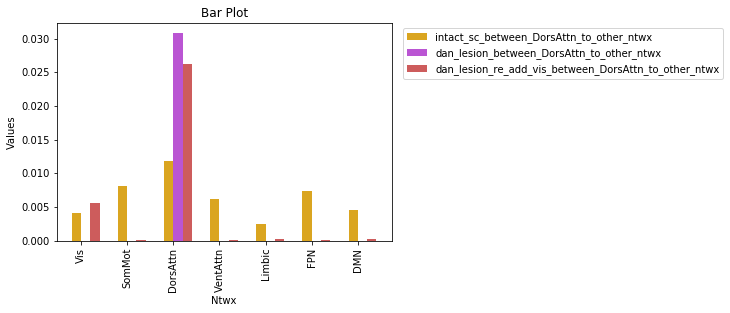

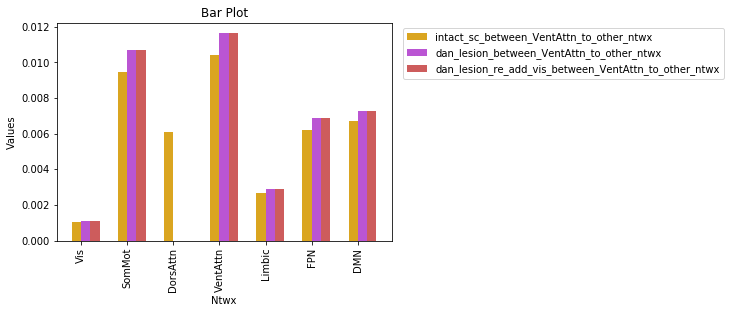

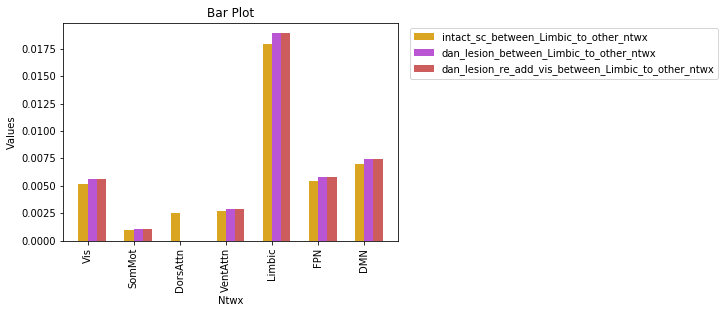

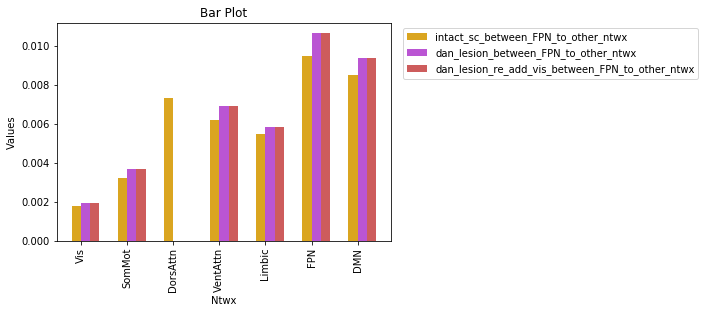

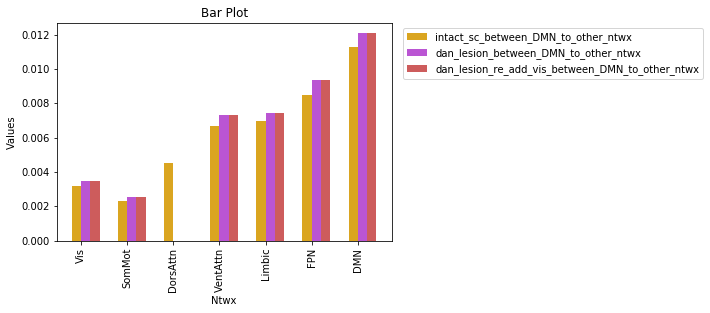

In [84]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dan_lesion_between_other_ntwx[j], width, label='dan_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], dan_lesion_re_add_between_other_ntwx[j], width, label='dan_lesion_re_add_vis_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

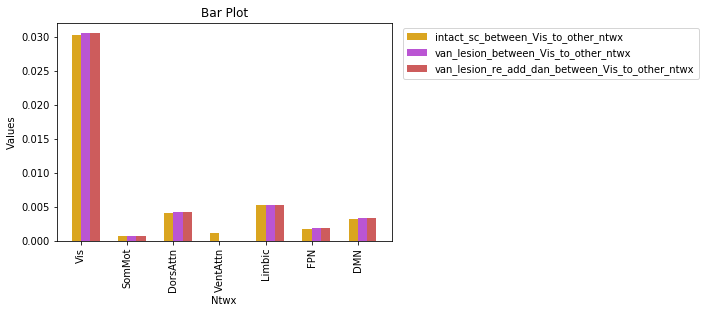

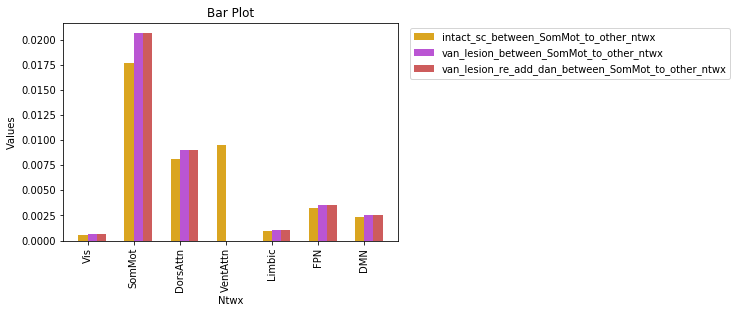

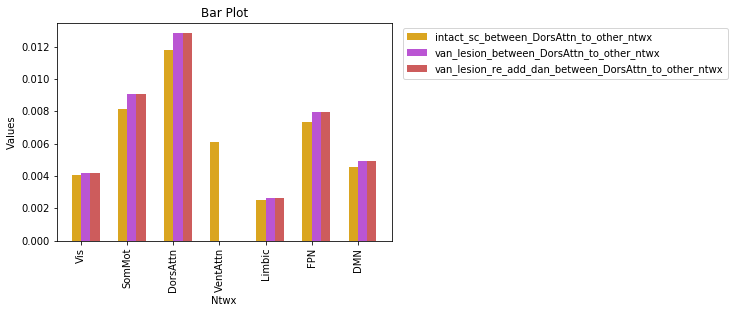

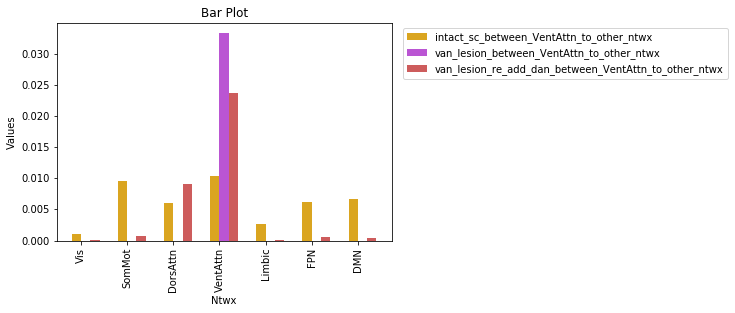

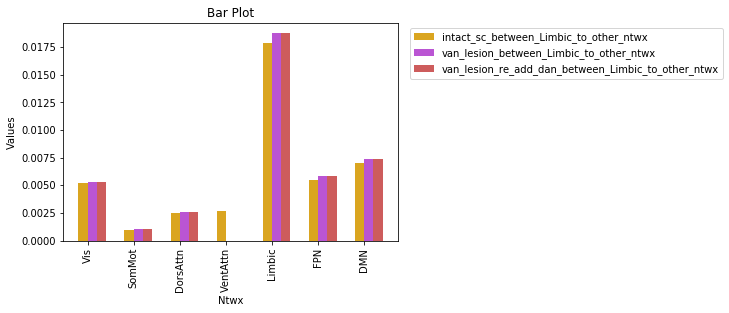

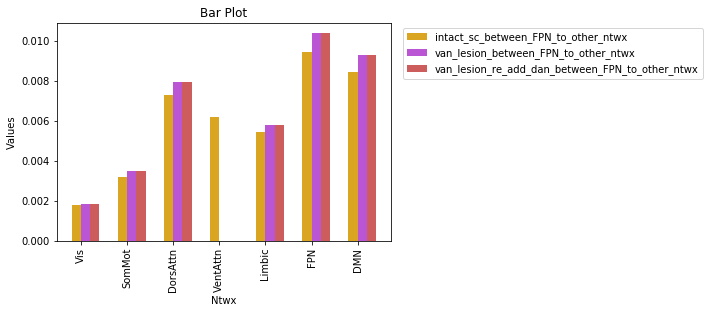

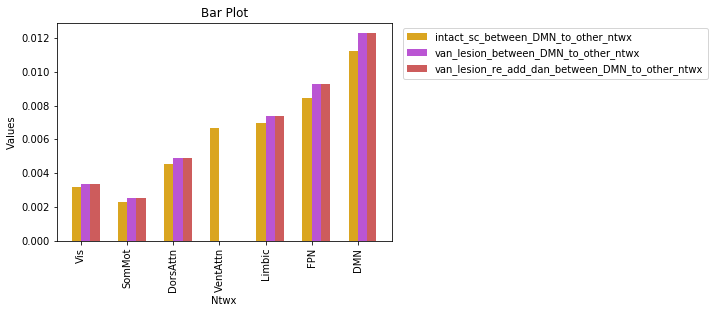

In [85]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], van_lesion_between_other_ntwx[j], width, label='van_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], van_lesion_re_add_between_other_ntwx[j], width, label='van_lesion_re_add_dan_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### lim

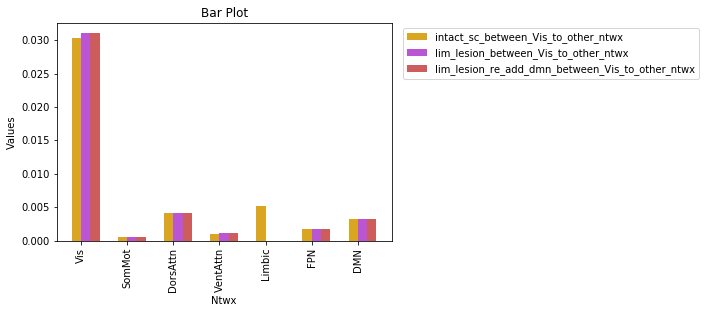

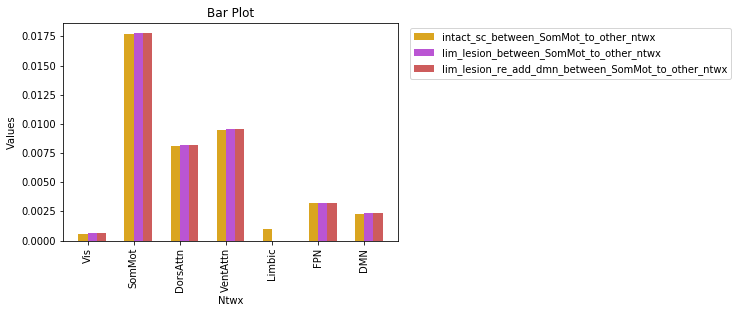

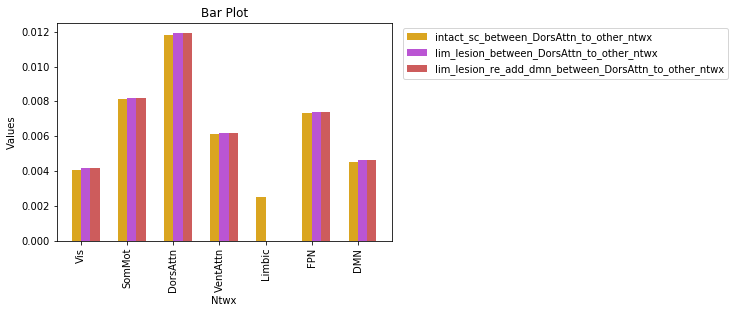

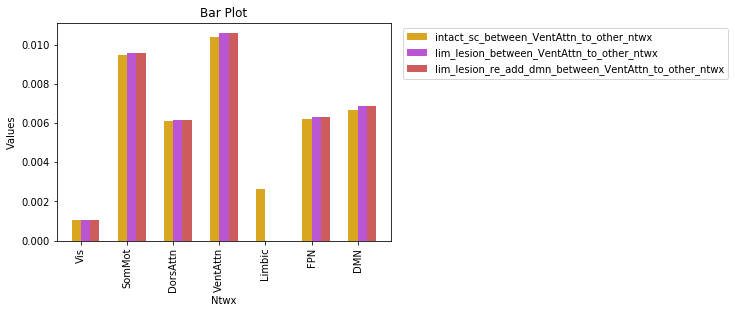

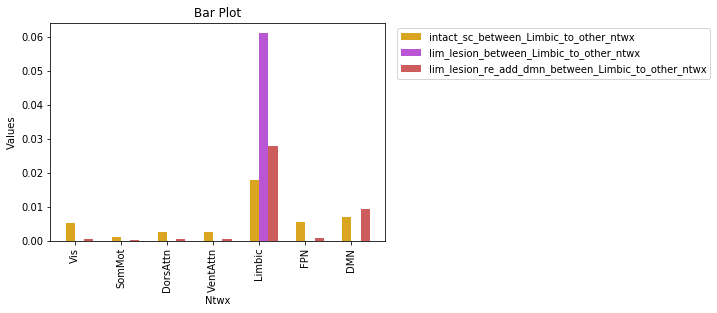

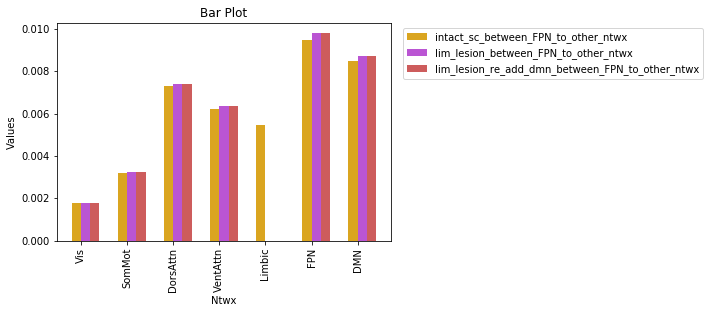

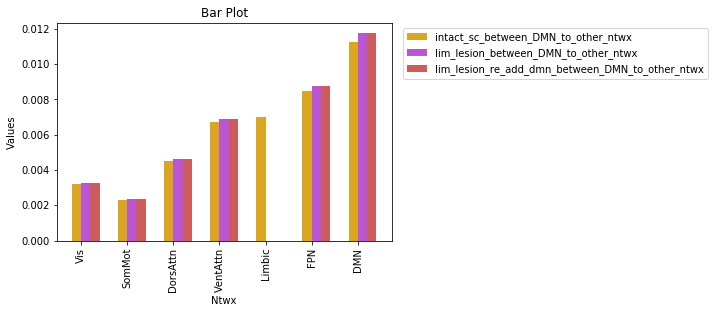

In [86]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], lim_lesion_between_other_ntwx[j], width, label='lim_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], lim_lesion_re_add_between_other_ntwx[j], width, label='lim_lesion_re_add_dmn_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

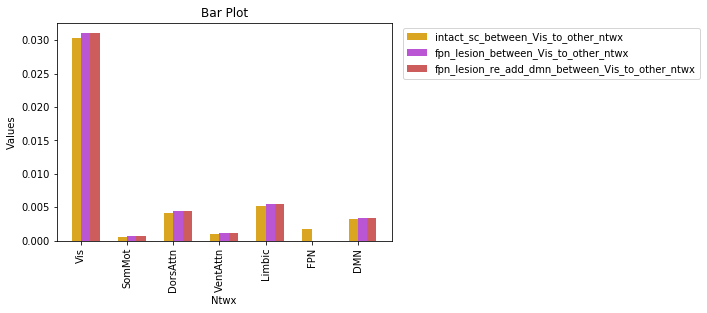

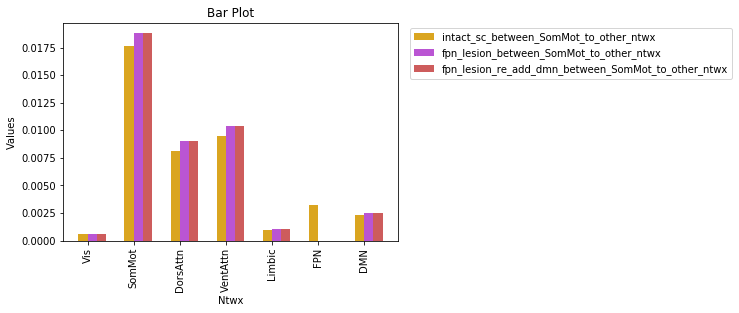

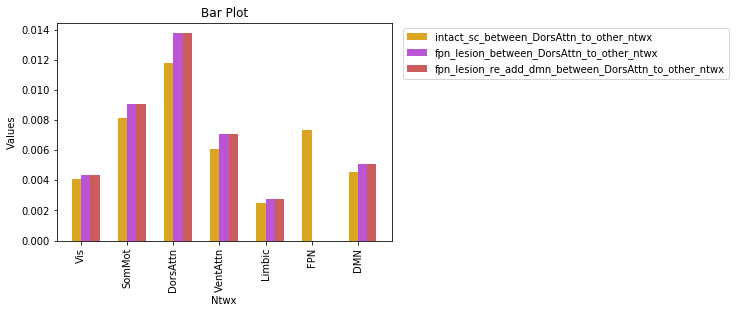

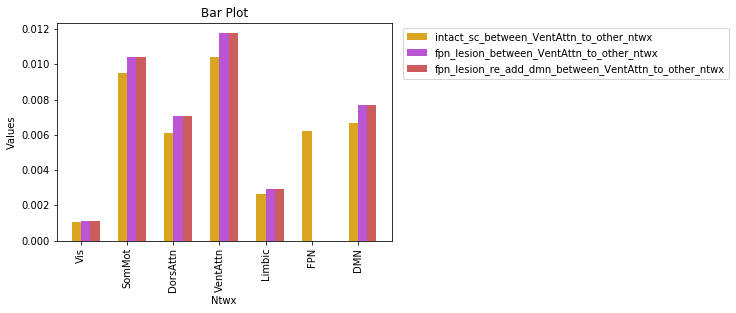

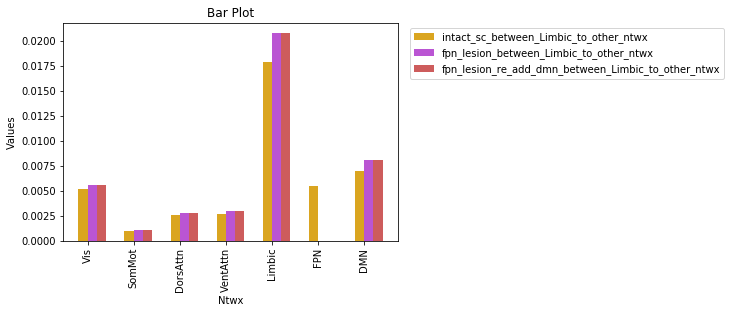

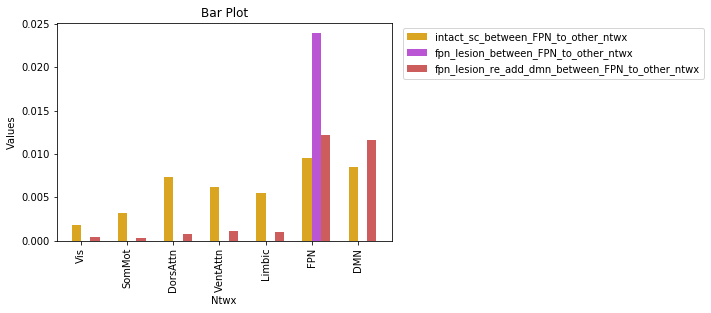

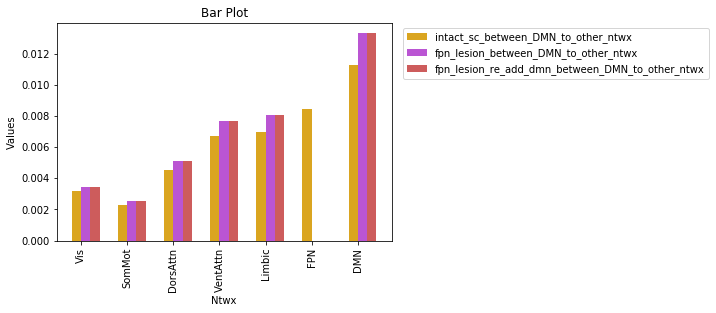

In [87]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], fpn_lesion_between_other_ntwx[j], width, label='fpn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], fpn_lesion_re_add_between_other_ntwx[j], width, label='fpn_lesion_re_add_dmn_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

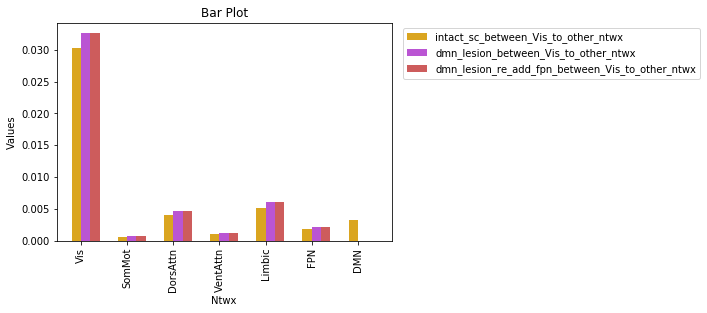

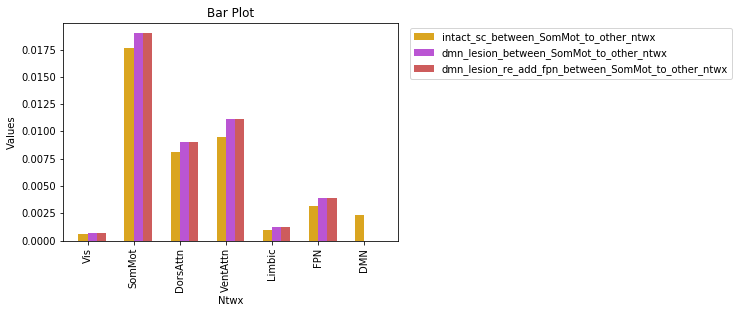

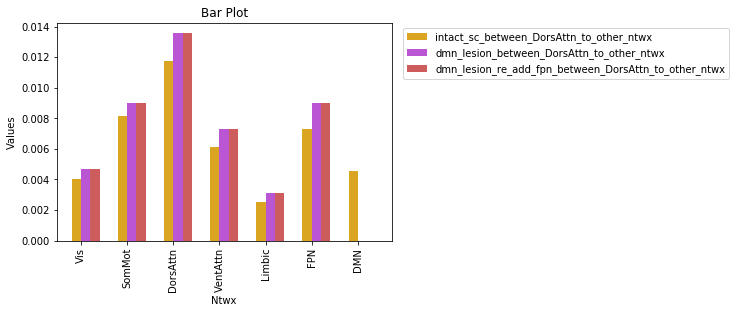

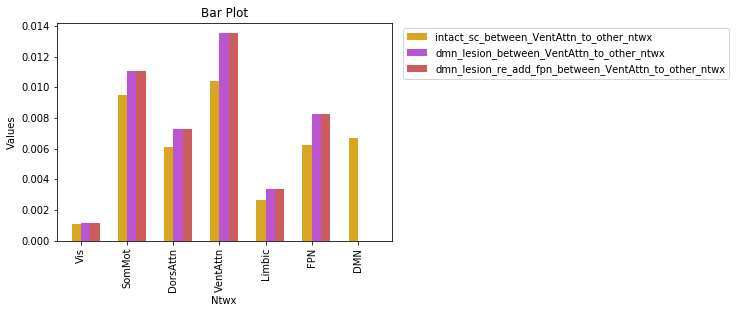

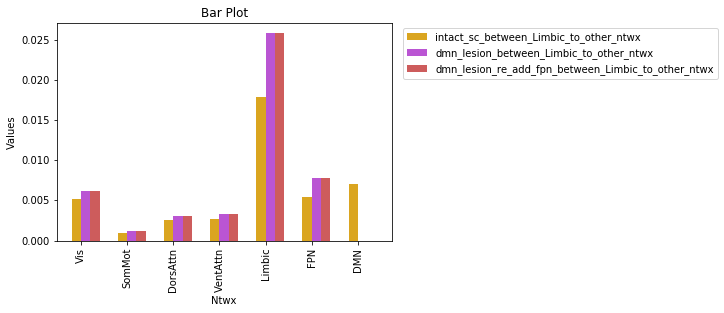

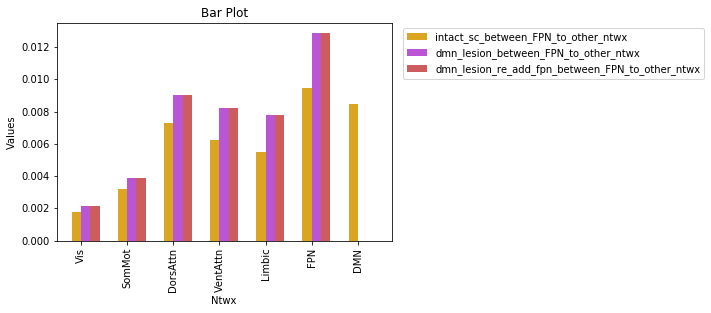

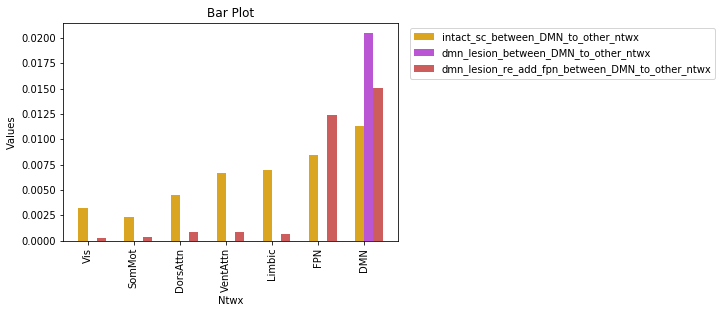

In [89]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.20  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dmn_lesion_between_other_ntwx[j], width, label='dmn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    rects3 = ax.bar([i + 2*width for i in x], dmn_lesion_re_add_between_other_ntwx[j], width, label='dmn_lesion_re_add_fpn_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='indianred')
    
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()